# KerasNLP Disaster Tweets
- To build a machine learning moel that predict which Tweets are real disasters and which are not
- We will use 10,000 labelled tweets for training
- We will use `DistilBERT` from keras - a pretrained model

In [1]:
# setting environment
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 19.3 MB/s eta 0:00:0000:01
  Attempting uninstall: keras-core
    Found existing installation: keras-core 0.1.5
    Uninstalling keras-core-0.1.5:
      Successfully uninstalled keras-core-0.1.5


In [3]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import warnings

# set options
warnings.filterwarnings('ignore')

# check version
print("TensorFlow version: ", tf.__version__)
print("KerasNLP version: ", keras_nlp.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend
TensorFlow version:  2.12.0
KerasNLP version:  0.6.2


In [5]:
# load dataset
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# check the shape and memory usage
print("Train shape: ", df_train.shape)
print("Test shape: ", df_test.shape)
print("Train memory usage: ", df_train.memory_usage().sum()/1024**2, " MB")
print("Test memory usage: ", df_test.memory_usage().sum()/1024**2, " MB")

Train shape:  (7613, 5)
Test shape:  (3263, 4)
Train memory usage:  0.29053497314453125  MB
Test memory usage:  0.099700927734375  MB


In [6]:
# check the first 5 rows of train dataset
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# check the first 5 rows of test dataset
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Dataset Exploration

In [8]:
# making lengthe feature
df_train['length'] = df_train['text'].apply(lambda x: len(x))
df_test['length'] = df_test['text'].apply(lambda x: len(x))

# print the length description
print('Train length description: ')
print(df_train['length'].describe())
print('\nTest length description: ')
print(df_test['length'].describe())

Train length description: 
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test length description: 
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


# Data Preprocessing

In [11]:
# setting the variables
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = NUM_TRAINING_EXAMPLES * TRAIN_SPLIT // BATCH_SIZE
EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [13]:
# train test split
from sklearn.model_selection import train_test_split
X = df_train['text']
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test['text']

# Loading the DistillBERT model
- Berfore inputting into BERt, text inputs need to be transformed to numeric token ids and arranged in several Tensors
- `BERTClassifier` model can be configured with preprocessor layer (automatic apply preprocessing to raw inputs during `fit, predict, evaluate`) 
- This is default when creating the model with `from_preset()`
- We will use `DistillBERT` as it learns a distilled version of BERT, retaining 97% performance with only half the number of parameters
- The model has 40% lesser parameters but runs 60% faster while preserving over 95% of BERT's performance measured using GLUE language understanding benchmark
- It does not have token-type embeddings, pooler and retains only half the layers from Google's BERT

In [15]:
# load DistilBERT model 
preset = 'distil_bert_base_en_uncased'

# use shorter sequence length
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160, name='preprocessor_4_tweets')

# pretrained classifier
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor=preprocessor, num_classes = 2)
classifier.summary()

231508/231508 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       
265570304/265570304 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │           0 │ distil_bert_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

# Train our own model and fine-tuning BERT

In [16]:
# compile 
classifier.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate=1e-5),
    metrics = ['accuracy']
)

# fit
history = classifier.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val, y_val),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE
)

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 128s 426ms/step - accuracy: 0.7143 - loss: 0.5630 - val_accuracy: 0.8457 - val_loss: 0.3931
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 47s 246ms/step - accuracy: 0.8416 - loss: 0.3782 - val_accuracy: 0.8464 - val_loss: 0.3869


In [17]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(y_true, np.argmax(y_pred, axis = 1), display_labels = ['Not Disaster', 'Disaster'], cmap = plt.cm.Blues)
    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis = 1)).ravel()
    f1_score = tp / (tp + 0.5 * (fp + fn))
    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step


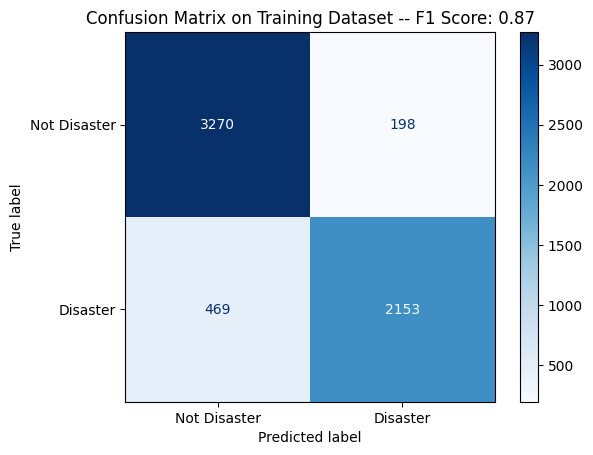

In [18]:
y_pred_train = classifier.predict(X_train)
displayConfusionMatrix(y_train, y_pred_train, 'Training')

48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step


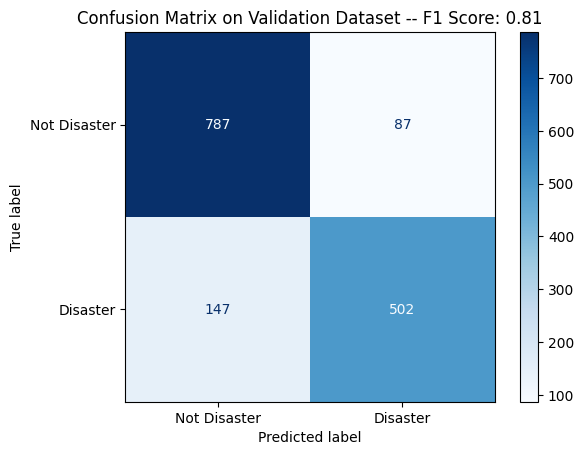

In [19]:
y_pred_val = classifier.predict(X_val)
displayConfusionMatrix(y_val, y_pred_val, 'Validation')

# Submission

In [20]:
# Generate the submission file
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [21]:
sample_submission['target'] = np.argmax(classifier.predict(X_test), axis = 1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step


In [22]:
# describe the submission file
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.377873
std,3146.427221,0.484930
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [23]:
# save the submission file
sample_submission.to_csv('submission.csv', index=False)